In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ch 05 서포트 벡터 머신
* 서포트 벡터 머신$^{support-vector-machine}$은 다목적 머신러닝 모델이다. 
    * 강력하고 선형, 비선형 분류, 회귀, 이상치 탐색
* 특히 복잡한 분류 문제에 잘 들어 맞고 중간 크기 이하의 데이터셋에 적합하다.

## 선형 SVM 분류

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

그림 저장: large_margin_classification_plot


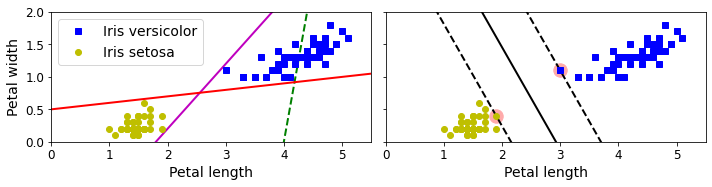

In [3]:
# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5


def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)


fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

* 왼쪽 그래프에 3개의 선형분류기에서 만들어진 결정 경계가 보인다. 
    * 점선을 제외한 두 실선 분류기는 잘 분류를 하고 있다. 
        * 하지만 결정 경계가 샘플에 너무 가까워 새로운 샘플에 대해서는 잘 작동하지 못할 것이다. 
* 오른쪽 그래프에 있는 실선은 SVM 분류기의 결정 경계이다. 
    * 제일 가까운 훈련 샘플로부터 가능한 멀리 떨어져 있다. 
    * 클래스 사이에 가장 폭이 넓은 도롤르 찾는것으로 생각 할 수 있다. (라지 마진 분류$^{large-margin-classification}$
    * 도로 바깥쪽에 훈련 샘플을 추가해도 결정 경계에는 영향을 주지 않는다. 
    * 도로 경계에 위치한 샘플에 의해 전적으로 결정 되고 이런 샘플을 서포트 벡터$^{support-vedctor}$라 한다. (핑크 동그라미)


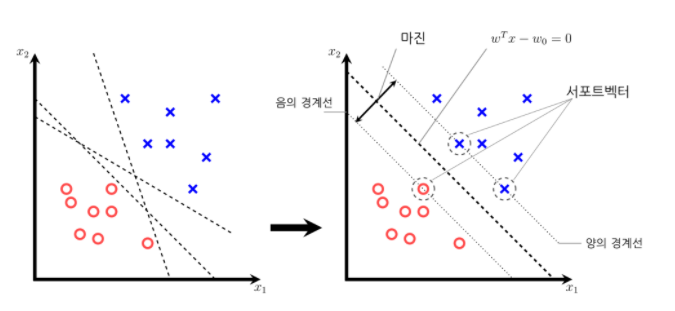

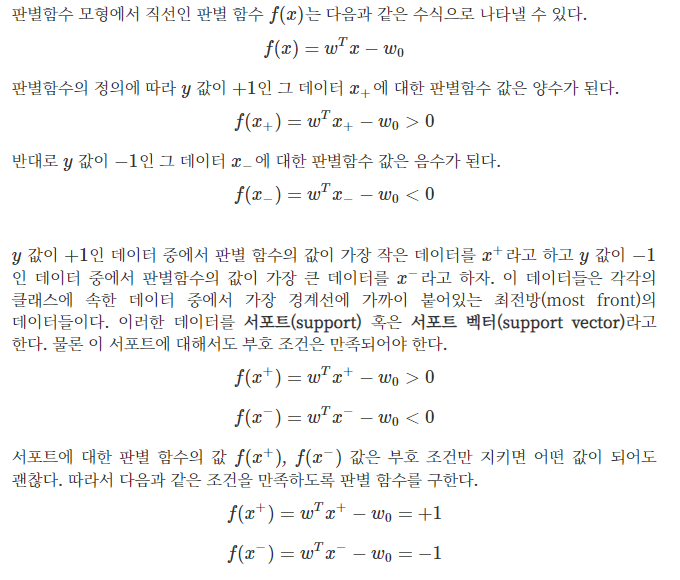

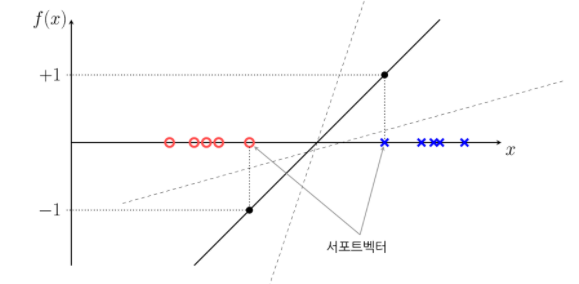

판별 경계선 $f(x) = 0$ 과 점 $x^{+}, x^{-}$의 거리를 계산하고 합을 마진이라고 하며 마진 값이 클 수록 경계선이 더 안정적이라고 볼 수 있다. 

### 특성의 스케일에 민감함

그림 저장: sensitivity_to_feature_scales_plot


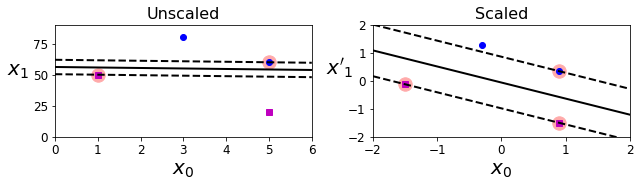

In [4]:

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

* 왼쪽 그래프에서는 수직축의 스케일이 수평축보다 훨씬커서 도로가 수평에 가깝게 된다. 
* 우측과 같이 특성의 스케일을 조절하면(sklearn의 StandardScaler) 더 좋다. 

### 소프트 마진 분류

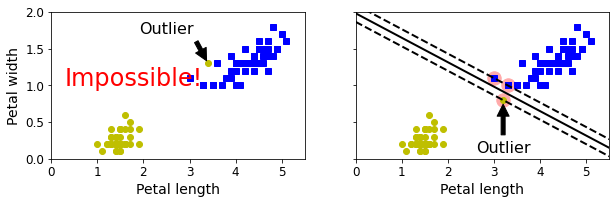

In [5]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.show()

* 모든 샌플이 도로 바깥에 분류되면 하드 마진 분류$^{hard-margin-classification}$이다.
    * 데이터가 선형적으로 구분될 수 있어야 제대로 작동하고 이상치에 민감하다.
* 왼쪽 그래프에서는 하드 마진을 찾을 수 없다. 
* 오른쪽 그래프의 결정 경계는 처음의 그림과 매우 다르고 일반화가 잘 되지 않을것 같다. 

이런 문제를 피하려면 유연한 모델이 필요하다.
도로의 폭을 가능한 넓게 유지하는 것과 마진 오류$^{margin-violatoin}$사이에 적절한 균형을 잡아야 한다. 이를 소프트 마진 분류$^{soft-margin-classification}$이라 한다.

### 라지 마진 vs 마진 오류

In [6]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()   # 꽃 데이터 
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),  # 스케일 맞추기
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [7]:
iris["data"].shape

(150, 4)

In [8]:
X.shape

(150, 2)

In [9]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

#### NOTE
* SVM 분류기는 로지스틱 회귀 분류기와는 다르게 클래스에 대한 확률을 제공하지 않는다. 
* sklearn의 LinearSVC는 predict_proba()를 제공하지 않지만 SVC 모뎅른 probability = True 로 지정하면  predict_proba()를 제공한다. default = False

In [10]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)     #하이퍼 파라미터 C 비교
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

C:\Users\Openingsound\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [11]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_   # coef 가중치
svm_clf1.intercept_ = np.array([b1])     # intercept 편향
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel() #ravel()1차원화 
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

(4.0, 5.9, 0.8, 2.8)

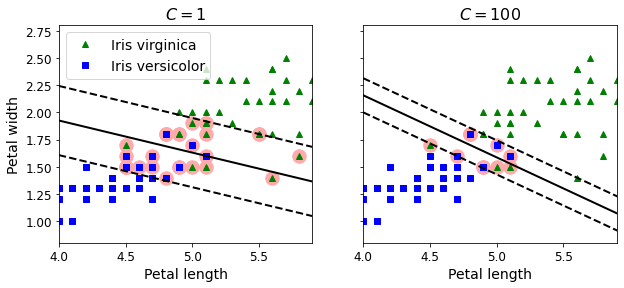

In [12]:

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9) # 위에서 함수 선언함
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

* C는 하이퍼 파라미터중 하나다
* 마진오류는 나쁘므로 일반적으로 적은것이 좋다. 하지만 이 경우에는 왼쪽 모델이 마진오류가 더 많지만 일반화가 더 잘 된거 같다. 
* SVM 모델이 overfitting이면 C를 감소시켜 규제할 수 있따. 

LinearSVC 클래스를 대신 선형 커털을 사용하는 SVC로 대채 가능하다.
SVC(kernel = "linear", C= 1)라고 쓰거나 SGDClassifier(loss = "hinge", alpha = 1 / (m * C)) 와 같이 SGDClassifier모델을 사용하는 것이다. (4장의 확률적 경사 하강법을 적용한다.)

#### TIP
* LinearSVC는 규제에 편향을 포함시키 때문에 Train Set에서 평균을 빼서 중앙에 맞춰 줘야 한다. StandardScaler를 사용하면 자동으로 된다. 또한 Loss 매개 변수를 "hinge"로 설정 해 줘야 한다. 마지막으로 샘플보다 특성이 많지 않다면 성능을 높이기위해  dual 매개변수를 False로 지정 해줘야 한다. 

## 비선형 SVM 분류

선형적으로 분류할 수 없는 데이터셋이 많다.  따라서 4장에서처럼 다항 특성과 같은 특성을 더 추가 할 수 있다. 

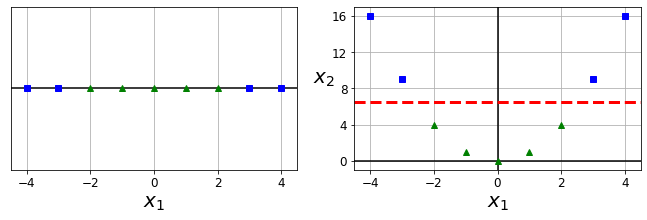

In [13]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

* 왼쪽 그래프는 하나의 특성 $x_1$만을 가진 간단한 데이터 셋이다.  이는 선형적으로 구분이 안된다. 
* 두번째 특성 $x_2 = (x_1)^2$을 추가하여 만들어진 2차원 데이터셋은 완벽하게 선형적으로 구분할 수 있다. 
* sklearn을 이용하여 이를 하려면 4.3 의 PolynimialFeatures변환기와 StndardSclaer, LinearSVC를 연결하여 PipeLine을 만든다.

### moons

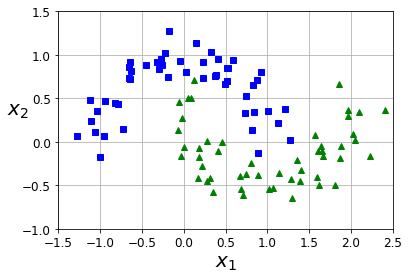

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

C:\Users\Openingsound\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

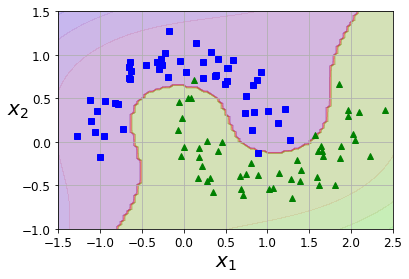

In [16]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s) # 모든 쌍을 만들어줌
    X = np.c_[x0.ravel(), x1.ravel()] # 1차원 변환
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2) # 채워진 등고선
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### 다항식 커널

다항식 특성을 추가하는건 모든 알고리즘에서 간단하고 잘 작동한다. 
SVM을 사용할 때는 커널 트릭$^{kernel-trick}$이라는 개쩌는 수학적 기교를 쓸 수 있다. 

#### 커널 트릭
* 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있다. 
* 실제로는 어떤 특성도 추가하지 않았기 때문에 엄청난 수의 특성 조합이 생기지 않는다. 

In [17]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [18]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

그림 저장: moons_kernelized_polynomial_svc_plot


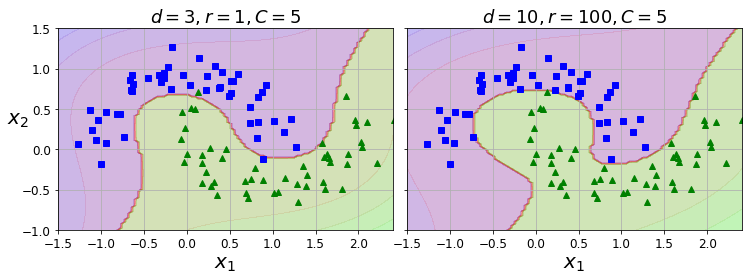

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

* 왼쪽은 3차 다항식 커널을 사용해 SVM분류기를 훈련 시킨다. 
* 오른쪽은 10차 다항식 커널을 사용한 또다른 SVM분류기 이다. 
* 과대적합이면 차수를 줄여야 한다. 
* 매개변수 coef0 는 가중치로 모델이 차수에 얼마나 영향을 받을지 조절 한다.
    * 식 5-10 의 다항식 커널에 있는 상수항 $r$이다. 
    * 다항식 커널은 차수가 높아질수록 1보다 작은 값과 1보다 큰 값의 차이가 크게 벌어지므로 coef0을 적절하게 지정하면 고차항의 영향을 줄일수 있고 default는 0이다. 

#### TIP
* 적절한 하이퍼파라미터를 찾는 방법은 그리드 탐색을 사용하는 것이다.
* 처음에는 그리드의 폭을 크게하여 빠르게 검색하고 그 다음에는 최적값을 찾기위해 그리드를 세밀하게 검색한다. 

### 유사도 특성

그림 저장: kernel_method_plot


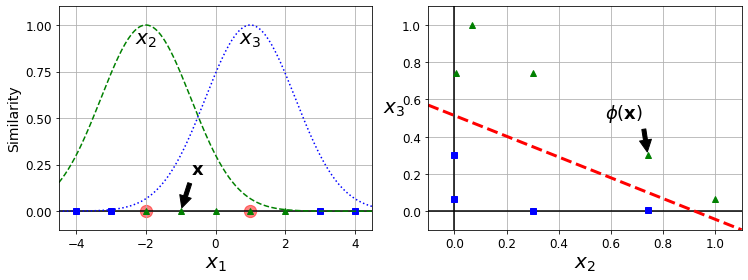

In [20]:

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In [21]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


각 샘플이 특정 랜드마크$^{landmark}$와 얼마나 닮았는지 측정하는 유사도 함수$^{similarity-function}$로 계산한 특성을 추가하는 것 이다.
예를 들어 앞의 1차원 데이터셋에 두개의 랜드마크 $x_1 = -2$와 $x_1 = 1$을 추가한다.(왼쪽) 그리고 $\gamma = 0.3$인 가우시안 방사 기저 함수$^{radial-basis-function}$ (RBF)를 유사도 함수로 정의 하자

식 5-1: 가우시안 RBF

$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$

* 이 함수의 값은 0~1까지 변화하며 종 모양으로 나타난다. (1이 랜드마크와 같은 위치)
* $\ell$이 랜드마크 지점이다. $\gamma$는 0보다 커야하며 값이 작을수록 폭이 넓은 종모양이 된다.

랜드마크를 선택하는 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것이다. 이렇게 하면 차원이 매우 커지고 세트가 선형적으로 구분될 가능성이 높다. 
닩범은 n개의 특성을 가진 m개의 샘플이 m개의 특성을 가진 m개의 샘플로 변환 된다. (원본 특성 제외)

### 가우시안 RBF 커널을 사용한 SVC모델

유사도 특성 방식도 유용하게 사용될 수 있다.
추가 특성을 모두 계산하려면 연산 비용이 많이 드는데 특히 훈련 세트가 클 경우 더 그렇다. 
여기서 커널 트릭이 SVM에 마법을 만든다. 
유사도 특성을 많이 추가하는 것과 같은 비슷한 결과를 얻을 수 있다.

In [22]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

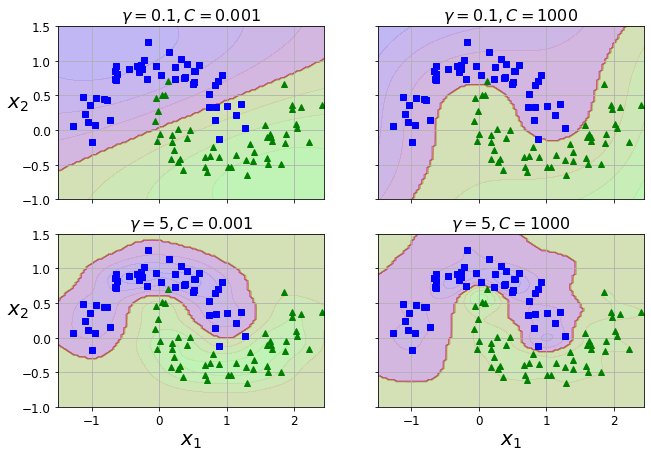

In [23]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

* $\gamma$를 증가시키면 각 샘플의 영향 범위가 작아진다. 결정 경계가 조금더 불규칙해지고 각 샘플을 따라 구불구불하게 휘어진다. 
* 반대로 작은 $\gamma$ 값은 넓은 종모양 샘플을 만들며샘플이 넓은 범위에 걸쳐 영향을 주므로 결정 경계가 더 부드러워 진다. 
* $\gamma$가 규제의 역할을 한다. 
* $\gamma$와 C를 함께 조절 해아 한다. 

그림 저장: moons_rbf_svc_plot


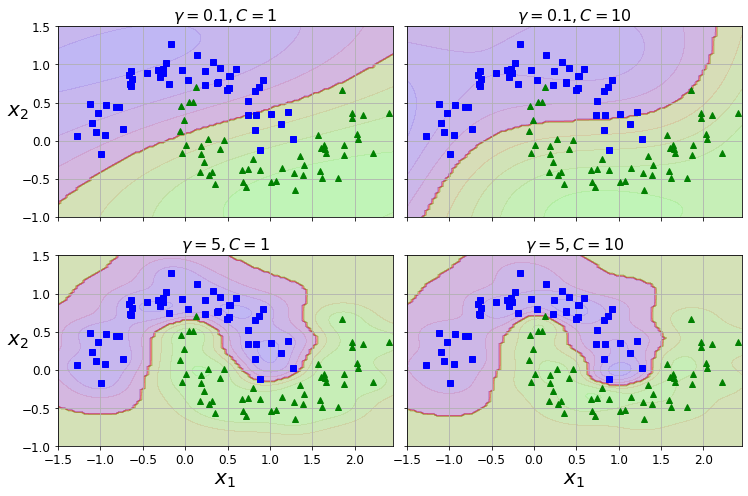

In [24]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 1, 10
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

#### TIP
* 문자열 커 널$^{string-kernel}$이 가끔 txt문서나 DNA 서열을 분류 할 때 사용된다. 
* 여러가지 커널중 언제나 선형 커널을 먼저 사용해야 한다. (LinearSVC 가 SVC(kernel ="lnear") 보다 훨씬 빠르다. 
* 세트가 너무 크지 않다면 가우시안 RBF커널도 시도해보면 좋다. 대부분의 경우 이 커널이 잘 들어 맞는다. 시간과 컴퓨팅 성능이 충분하면 교차 검증과 그리드 탐색을 사용해 다른 커널도 좀 더 시도해볼 수 있다. 

### 계산 복잡도

LinearSVC 는 커널 트릭을 지원하지 않지만 훈련 시간 복잡도는 $O(m * n)$이다.
정밀도를 높이면 알고리즘의 수행 시간이 길어진다. 하이퍼파라미터 $\eta$  로 조절 가능하다. sklearn에서는 매개변수 tol 이다. 대부분의 경우 기본값으로 두면 잘 작동한다. 
SVC는 훈련 시간 복잡도는  $O(m^2 * n)$과  $O(m^3 * n)$ 사이이다.
이는 복잡하지만 작거나 중간 규모의 훈련세트에 적당하다.
하지만 특성의 개수에는, 특히 희소 특성$^{sparse-features}$(각 샘플에 0이 아닌 특성이 몇개 없는 경우) 인 경우에는 잘 확장 된다. 이런 경우 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 편균 수에 비례 한다.

커널 트릭은 SVC만 가능

## SVM 회귀

SVM을 분류가 아니라 회귀에 적용하는 방법은 목표를 반대로 하는 것이다.
일정한 마진 오류 안에서 도로폭이 가능한 최대가 하는 대신 SVM 회귀는 제한된 마진 오류 (도로 밖의 샘플) 안에서 도로 안에 가능한 많은 샘플이 들어가도록 학습한다.
도로 폭은 $\epsilon$로 조절한다.(허용오차의 $\epsilon$와는 다르다.

In [25]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [26]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [27]:
print(X.shape,y.shape)

(50, 1) (50,)


In [33]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    #print(off_margin.shape)
    return np.argwhere(off_margin) # argwhere 해당 값의 위치를 반환 0~ 49 

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)
print(svm_reg1.support_)
eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

[[ 7]
 [14]
 [25]
 [31]
 [33]
 [34]
 [39]
 [42]]


## 추가 설명
https://datascienceschool.net/view-notebook/6c6d450cb2ee49558856fd924b326e00/
SVC를 사용하여 모형을 구하면 다음과 같은 속성값을 가진다.

* n_support_: 각 클래스의 서포트의 개수
* support_: 각 클래스의 서포트의 인덱스
* support_vectors_: 각 클래스의 서포트의 x 값.  x+ 와  x− 
* coef_:  w  벡터
* intercept_:  −w0 
* dual_coef_: 각 원소가  ai⋅yi 로 이루어진 벡터

그림 저장: svm_regression_plot


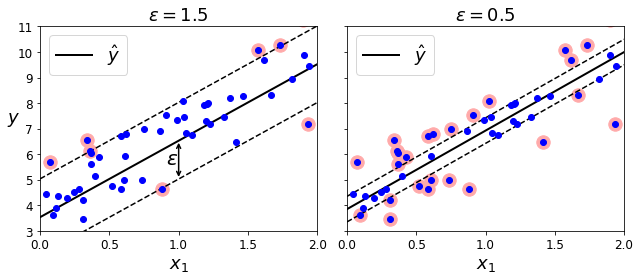

In [34]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

그림 5 - 10

* 마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없다. 
* 이모델을 $\epsilon$에 민감하지 않다. 라고 한다.

### sklearn의 LiearSVR을 사용해 선형 SVM 회귀 적용 하기

먼저 훈련 데이터의 스케일을 맞추고 평균을 0으로 맞춰야 한다.

In [35]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

비선형 회귀 작업을 하려면 커널 SVM모델을 사용해야 한다.

In [36]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [37]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

그림 저장: svm_with_polynomial_kernel_plot


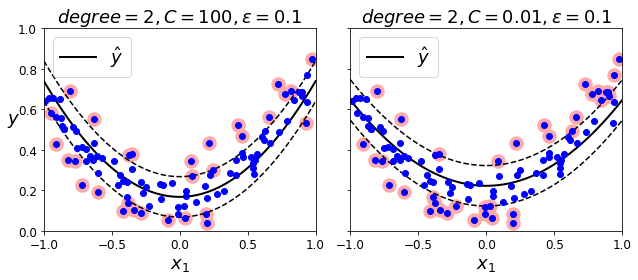

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

* 규제 C가 거의 없는 왼쪽 
* 오른쪽 그래프는 규제가 많다.

SVR은 SVC의 회귀 R 버전이고 LinearSVR은 LinearSVC의 회귀 버전이다. 
LinearSVR은 시간이 선형적으로 늘어나지만 SVR 은 훨씬 느려진다.

## SVM 이론
편향을 $b$ 라 하고 특성의 가중치 벡터를 $\mathbf{w}$라 한다. 따라서 입력 특성 벡터에 편향을위한 $x_0 = 1$이 추가되지 않는다.

식 5-2: 선형 SVM 분류기의 예측

$
\hat{y} = \begin{cases}
 0 & \mathbf{w}^T \mathbf{x} + b \lt 0 \text{ 일 때} \\
 1 & \mathbf{w}^T \mathbf{x} + b \geq 0 \text{ 일 때}
\end{cases}
$

* 결정함수 $h =  \mathbf{w}^T \mathbf{x} + b = w_1 x_1 + ... + w_n x_x + b$ 를 계산해서 새로운 샘플 $\mathbf{w}$의 클래스를 예측한다. 0보다 크면 1 작으면 0인 음성 클래스가 된다.

In [39]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

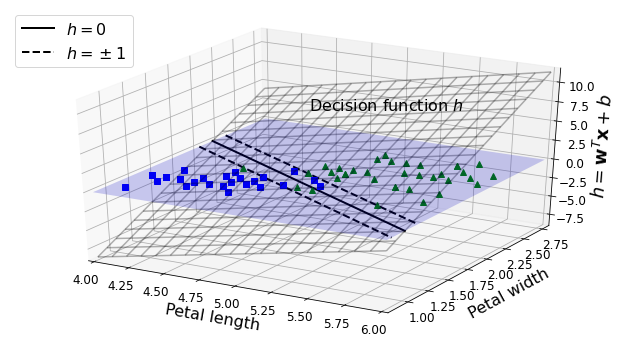

In [40]:

from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

plt.show()

* 특성이 두개 (너비와 길이) 인 데이터 셋이기 때문에 2차원 평면이다. 
* 결정 경계는 결정 함수의 값이 0 인 지점들로 이뤄져 있고 결정 함수와의 교차점으로 직선이다.
* 점선은 결정 함수 값이 1 or -1인 점이다. 결정 경계에 나란하고 일정한 거리만큼 떨어져 마진을 형성하고 있다. 
* 선형 SVM 분류기를 훈련하다는 건 마진오류를 하나도 발생하지 않거나(하드 마진) 제한적인 마진오류를 가지면서 (소프트 마진) 가능한 마진을 크게하는 $\mathbf w$와 $b$를 찾는 것이다.

### 목적 함수
#### 작은 가중치 벡터가 라지 마진을 만든다.

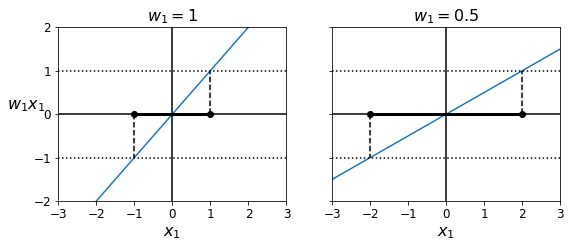

In [41]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.show()

그림 5-13

* 결정함수의 기울기는 가중치 벡터의 노름 $||\mathbf w ||$와 같고 기울기를 2로 나누는건 결정 경계(결정 함수의 값이 $\pm 1$)로 부터 2배 멀어지기 때문에 마진에 2를 곱하는것과 같다. 

식 5-3: 하드 마진 선형 SVM 분류기 목적 함수

$ \begin{split} &\underset{\mathbf{w}, b}{\operatorname{minimize}}\quad{\frac{1}{2}\mathbf{w}^T \mathbf{w}} \\ &\text{[조건]}  \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 \quad \text{일 때} i = 1, 2, \dots, m \end{split} $

마진을 크게하기위해 $||\mathbf w ||$를  최소화 해야 한다.

하드마진을 하려면 결정 함수가 모든 양성 훈련 샘플에선 보다 크고 음성에선 -1보다 작아야 한다. 음성 $(y^{(i)} = 0)$ 일때 $t^{(i)} = -1$로 양성 샘플 $(y^{(i)} = 1)$ 일때 $t^{(i)} = 1$로 정의하면 모든 샘플에서 식 5-3과 같이 표현 가능하다.(제약이 있는 최적화$^{constrained-optimization}$)

#### NOTE
$||\mathbf w ||$를 최소화 하는 대신 $\frac{1}{2} ||\mathbf w ||^2$ 인 $\frac{1}{2}\mathbf{w}^T \mathbf{w} $를 최소화 한다. 

소프트 마진 분류기의 목적 함수를 구성하려면 각 샘플에 대해 슬랙 변수$^{slack-variable}$ $\zeta^{(i)} \ge 0 $을 도입해야 한다.$\zeta^{(i)}$는 $i$번째 샘플이 얼마나 마진을 위반할지 정한다.

식 5-4: 소프트 마진 선형 SVM 분류기 목적 함수

$ \begin{split} &\underset{\mathbf{w}, b, \mathbf{\zeta}}{\operatorname{minimize}}\quad{\dfrac{1}{2}\mathbf{w}^T \mathbf{w} + C \sum\limits_{i=1}^m{\zeta^{(i)}}}\\ &\text{[조건]} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)} \quad \text{and} \quad \zeta^{(i)} \ge 0 \quad \text{for } i = 1, 2, \dots, m \end{split} $

* 두가지 목표
    * 마진 오류를 최소화하기 위해 가능한 한 $\zeta^{(i)}$의 값을 작게 만드는것
    * 마진을 크게하기위해 $\frac{1}{2}\mathbf{w}^T \mathbf{w} $를 최소화 하는것
* 여기에 $C$가 등장하고 두 목표 사이의 trade-off를 정의한다.

#### 슬랙변수

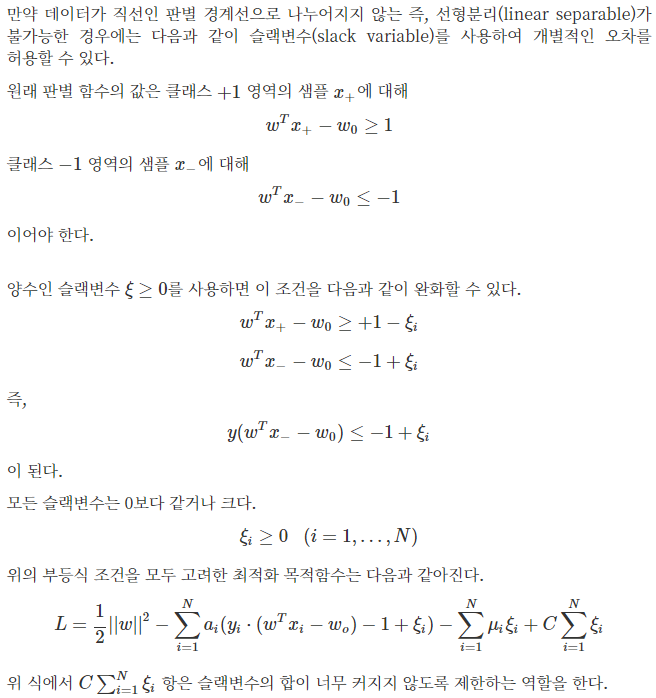

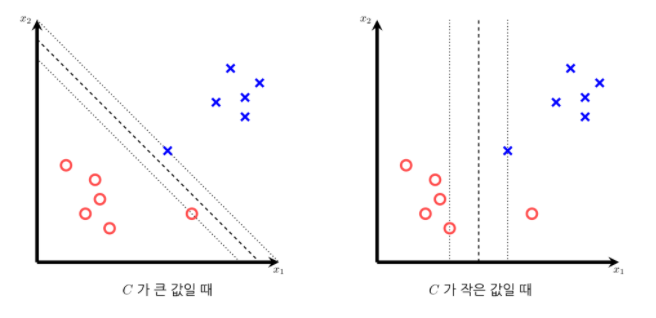

### 콰드라틱 프로그래밍

하드 마진과 소프트 마진 문제와 같이 선형적인 제약 조건이 있는 볼록 함수의 이차 최적화 문제를 콰드라틱 프로그래밍$^{quadratic-programming}$(QP) 문제라고 한다.

책 220p에 자세한 설명 있음

하드 마진 선형 SVM 분류기를 훈련시키는 한 가지 방법은 이미 준비되어 있는 QP 알고리즘에 관련 파라미터를 전달하는 것이다. 

이부분 질문!

### 쌍대 문제

원 문제$^{primal-problem}$라는 제약이 있는 최적화 문제가 주어지면 쌍대 문제$^{dual-problem}$라고 하는 깊게 관련된 문제로 표현할 수 있다. 일반적으로 쌍대 문제는 원 문제 해의 하한 값이지만 조건 하에서 원문제와 똑같은 해를 제공하고 SVM문제가 이와 같다.  책에 조건이 있다. 

책 223p

m이 n보다 작을때 원 문제보다 쌍대 문제를 푸는 것이 더 빠르다. 더 중요한 것은 운 문제에서는 적용이 안 되는 커널 트릭을 가능하게 한다.

### 커널 SVM

2차원 데이터셋에 2차 다항식 변환을 적용하고 선형 SVM 분류기를 변환된 이 훈련세트에 적용한다고 하자. 

식 5-8: 2차 다항식 매핑

$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  x_1 \\
  x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {x_1}^2 \\
  \sqrt{2} \, x_1 x_2 \\
  {x_2}^2
\end{pmatrix}
$

* 변한된 벡터는 2차원이 아닌 3차원이 된다. 

두개의 2차원 벡터 a와 b에 2차 다항식 매핑을 한뒤 벡터로 점곱$^{dot-product}$을 하면 다음과 같다.

식 5-9: 2차 다항식 매핑을 위한 커널 트릭

$
\begin{split}
\phi(\mathbf{a})^T \phi(\mathbf{b}) & \quad = \begin{pmatrix}
  {a_1}^2 \\
  \sqrt{2} \, a_1 a_2 \\
  {a_2}^2
  \end{pmatrix}^T \begin{pmatrix}
  {b_1}^2 \\
  \sqrt{2} \, b_1 b_2 \\
  {b_2}^2
\end{pmatrix} = {a_1}^2 {b_1}^2 + 2 a_1 b_1 a_2 b_2 + {a_2}^2 {b_2}^2 \\
 & \quad = \left( a_1 b_1 + a_2 b_2 \right)^2 = \left( \begin{pmatrix}
  a_1 \\
  a_2
\end{pmatrix}^T \begin{pmatrix}
    b_1 \\
    b_2
  \end{pmatrix} \right)^2 = (\mathbf{a}^T \mathbf{b})^2
\end{split}
$

* 변환된 벡터의 점곱이 원레 벡터의 점곱과 같다!!!!

모든 훈련 샘플에 변환 $\phi$를 적용하면 쌍대 문제(식 5-6)에 점곱 $\phi(\mathbf{X}^{(i)})^T \phi(\mathbf{X}^{(j)})$ 가 포함될 것이다. 하지만 $\phi$가 2차 다항식 변환 이라면(식 5-8) 변환 벡터의 점곱을 $(\mathbf{X}^{(i)^T}\mathbf{X}^{(j)})^2$ 으로 바꿀 수 있다. 즉 [식 5-6]에 있는 점곱을 제곱으로 바꾸면 된다.  이것이 커널 트릭이다.

함수 $K(\mathbf{a}, \mathbf{b}) = (\mathbf{a}^T \mathbf{b})^2$을 2차 다항식 커널 이라고 한다. 머신러닝에서 커널은 변환 $\phi$를 계산하지 않고 a와 b에 기반하여 $\phi(\mathbf{a})^T \phi(\mathbf{b}) $를 계산 할수 있는 함수이다.

식 5-10: 일반적인 커널

$
\begin{split}
\text{선형:} & \quad K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
\text{다항식:} & \quad K(\mathbf{a}, \mathbf{b}) = \left(\gamma \mathbf{a}^T \mathbf{b} + r \right)^d \\
\text{가우시안 RBF:} & \quad K(\mathbf{a}, \mathbf{b}) = \exp({\displaystyle -\gamma \left\| \mathbf{a} - \mathbf{b} \right\|^2}) \\
\text{시그모이드:} & \quad K(\mathbf{a}, \mathbf{b}) = \tanh\left(\gamma \mathbf{a}^T \mathbf{b} + r\right)
\end{split}
$

* 가장 널리 사용되는 커널의 일부이다. 
* 시그모이드 함수는 로지스틱 함수나 tanh함수와 같이 S모양의 곡선을 갖는 함수를 말한다.

#### 머서의 정리

머서의 정리에 따르면 머서의 조건(K가 매개변수에 대해 연속, 대칭임)이라부르는 몇개의 수학조건을 만족하면 a와 b를 (더 높은 차원이) 다른 공간에 매핑하는 $K(\mathbf{a}, \mathbf{b}) = \phi(\mathbf{a})^T \phi(\mathbf{b})  $ 와 같은 함수 $\phi$가 존재한다. 따라서 $\phi$ 를 정확히 몰라도 존재한다는것을 알기에 K를 커널로 사용할 수 있다. 
가우시안 RBF 커널의 경우  $\phi$ 는 각 훈련 샘플을 무한 차원의 공간에 매핑하는 것으로 볼 수 있따. (시그모이드 커널은 머서의 조건을 따르지 않음)

책 225p 와 226p에 커널 SVM으로 예측하기 및 커널트릭을 사용한 편향 계산이 있음

### 온라인 SVM

식 5-13: 선형 SVM 분류기의 비용 함수

$ J(\mathbf{w}, b) = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum\limits_{i=1}^{m}max\left(0, t^{(i)} - (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)} $

 원 문제로부터 유도된 [식 5-13]의 비용 함수를 최소화 하기 위한 경사 하강법을 사용한다. (SGDClassifier에서 loss 변수를 기본값인 "hinge"로 하면 선형 SVM이 된다.) 하지만 경사 하강법은 QP기반 방법보다 훨씬 느리게 수렴한다.

비용함수의 첫 번쨰 항은 모델이 작은 $\mathbf w$를 가지도록 제약을 가해 마진을 크게 만든다.

두번째 항은 모든 마진 오류를 계산한다. 어떤 샘플이 도로에서 올바른 방향으로 벗어나 있다면 마진 오류는 0이다. 그렇지 않다면 마진 오류는 올바른 방향의 도로 경계선 까지의 거리에 비례하다. 이 항을 최소화 하려면 마진오류를 가능한 줄이고 크기도 작게 해야 한다.

#### 힌지 손실

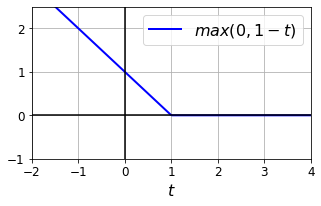

In [42]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
plt.show()

$max(0, 1 - t)$ 를 힌지 손실$^{hinge-loss}$라고 한다.  t =1에서 미분이 되지는 않지만, 라쏘 회귀 처럼 $t = 1$에서 서브그레이디언트를 사용해 경사 하강법을 사용할 수 있다. 
